### <h2 style="font-size: 40px;">Влияние новостей на стоимость акций</h2>

#### Техническое задание 

Разработать модель для анализа сентимента новостей, связанных с компанией «Русагро», и оценить их влияние на динамику стоимости акций.

#### Описание данных

* **`ragr_news.xlsx`** - новости из различных источников с 1 января 2025 по 30 апреля, которые содержат любое упоминание о компании.
    - `story_id` - уникальный индентификатор новости
    - `story_date` - дата появления новости в 12-часовом формате
    - `title` - заголовок новости
    - `text` - содержание новости
    - `language` - отечественный или иностранный ресурс (ru/en)
    - `source` - ссылка на ресурс новости
    - `url` - ссылка на новость
    - `char_length` - количество символов в новости
    - `token_count` - количество слов в новости


* **`ragr_prices.xlsx`** - файл с дневными ценами закрытия по ценам акции Русагро (с 17 февраля 2025 года).
    - `TRADEDATE` - дата торгов
    - `RGBI` - доходность гос. облигаций
    - `IMOEXF` - динамика индекса рынка акций MOEX
    - `RAGR` - цена закрытия акции
    - `Urals` - стоимость нефти марки Юралз

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import phik
import wordninja
import re
import torch
import torch.nn.functional as F

from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.preprocessing import MinMaxScaler

# Собственный русскоязычный словарь
wordninja.DEFAULT_LANGUAGE_MODEL = wordninja.LanguageModel('./russian_dictionary/ru_lang_utf8.txt.gz')
wordninja._SPLIT_RE = re.compile(r'\s+')

os.environ["TOKENIZERS_PARALLELISM"] = "false"

/home/serguntsov/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Загрузка данных

In [3]:
# Функция для быстрого ознакомления и парсинга таблицы
def parse_dataset(path):
    df = pd.read_excel(path)
    display(df.head())

    display(round(df.isna().mean() * 100, 2).sort_values(ascending=False).to_frame(name='Процент пропусков'))

    df.info()
    return df


# Функция для проверки наличия файла
def check_dataset(path):    
    if os.path.exists(path):
        return parse_dataset(path)
    else:
        print('Неправильный путь к файлу')

In [4]:
data_news = check_dataset('./datasets/ragr_news.xlsx')

,Unnamed: 0,story_id,story_date,title,text,language,source,url,char_length,token_count
0,4661,5358,1/1/2025 12:00:00 AM,Ц е н т р о б а н к Р Ф з а к р ы л д о ...,Ц е н т р о б а н к Р Ф з а к р ы л д о с т у ...,ru,https://m.interfax.ru/news/,https://m.interfax.ru/1001431,1375,315
1,15249,17527,1/3/2025 12:00:00 AM,В 2024 году Саратовская область зафиксировала ...,В 2024 году Саратовская область зафиксировала ...,ru,https://www.kommersant.ru/regions/64,https://www.kommersant.ru/doc/7421226,1200,247
2,46576,53356,1/9/2025 12:00:00 AM,Губернатор Вячеслав Гладков вручил Премию имен...,Губернатор Вячеслав Гладков вручил Премию имен...,ru,https://bel.aif.ru/,https://bel.aif.ru/society/gubernator-gladkov-...,3146,810
3,49578,57182,1/10/2025 12:00:00 AM,В П р и м о р ь е п о с е в н ы е п л о ...,В П р и м о р ь е п о с е в н ы е п л о щ а д ...,ru,https://tass.ru/ekonomika,https://tass.ru/ekonomika/22847513,2869,652
4,105012,120289,1/17/2025 12:00:00 AM,17.01.2025 10:31 В аграрном секторе России наз...,17.01.2025 10:31 В аграрном секторе России наз...,ru,https://ru24.net/moscow/rss/,https://ru24.net/moscow/395923374/,2513,529


,Процент пропусков
Unnamed: 0,0.0
story_id,0.0
story_date,0.0
title,0.0
text,0.0
language,0.0
source,0.0
url,0.0
char_length,0.0
token_count,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   529 non-null    int64 
 1   story_id     529 non-null    int64 
 2   story_date   529 non-null    object
 3   title        529 non-null    object
 4   text         529 non-null    object
 5   language     529 non-null    object
 6   source       529 non-null    object
 7   url          529 non-null    object
 8   char_length  529 non-null    int64 
 9   token_count  529 non-null    int64 
dtypes: int64(4), object(6)
memory usage: 41.5+ KB


Датасет **`data_news`** не содержит пропусков. Дату появления новости `story_date` необходимо привести в 24-часовой формат. Название и содержание новости требуют предобработки. Содержание новости `text` содержит заголовок новости и саму новость.

In [5]:
data_prices = check_dataset('./datasets/ragr_prices.xlsx')

,TRADEDATE,RGBI,IMOEXF,RAGR,Urals
0,2025-02-17,16.62,3319.5,216.34,60.395
1,2025-02-18,16.60,3264.0,210.50,61.015
2,2025-02-19,16.58,3285.0,221.92,62.110
3,2025-02-20,16.41,3298.0,219.52,62.550
4,2025-02-21,16.37,3295.0,219.02,60.500


,Процент пропусков
RGBI,4.05
TRADEDATE,0.00
IMOEXF,0.00
RAGR,0.00
Urals,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   TRADEDATE  74 non-null     datetime64[ns]
 1   RGBI       71 non-null     float64       
 2   IMOEXF     74 non-null     float64       
 3   RAGR       74 non-null     float64       
 4   Urals      74 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 3.0 KB


Датасет **`data_prices`** содержит 4% пропусков в признаке `RGBI`. По возможности, следует добавить данные с 1 января 2025 года.

#### Вывод загрузки данных

Датасеты связаны по дате. Данные в таблице **`data_news`** собраны за период *01.01.2025 - 25.04.2025*, в **`data_prices`** за *17.02.2025 - 29.05.2025*. \
В датасете **`data_prices`** содержатся пропуски.

### Предобработка данных

#### data_news

In [6]:
print('Количество дубликатов:', sum(data_news.duplicated(subset=['story_id'])))

Количество дубликатов: 0


In [7]:
data_news['story_date'] = pd.to_datetime(data_news['story_date'], format='%m/%d/%Y %I:%M:%S %p')

Дата `story_date` из **`data_news`** была переведена в формат 'YYYY-MM-DD'.

In [8]:
data_news.drop('Unnamed: 0', axis=1, inplace=True)

Колонка `Unnamed: 0` была удалена из датасета.

In [9]:
# Функция для предобработки обрезанных слов
def replace_match(match):
    spaced = match.group(0)
    glued = spaced.replace(' ', '')
    split = ' '.join(wordninja.split(glued))
    return split


# Функция для предобработки текста
def fix_spaced_words(text):
    spaced_word_pattern = r'(?:[А-Яа-яЁё]\s){4,}[А-Яа-яЁё]' # Нарезка

    text = re.sub(spaced_word_pattern, replace_match, text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'(\d+)\.\d+', r'\1', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower().replace('рус а гро', 'русарго')

    return text

In [10]:
data_news['title'] = data_news['title'].apply(lambda x: fix_spaced_words(x))
data_news['text'] = data_news['text'].apply(lambda x: fix_spaced_words(x))

Текст и заголовок новостей, имеющие нарезанные буквы (пример: 'П е р е ш е д ш и е н а п р я м о е в л а д е н и е'), были предобработаны, используя библиотеку wordninja с адаптацией под кириллицу. Данная реализация плохо восстанавливает названия компаний и аббревиатуры даже при их наличии в словаре. \
Были убраны ссылки, спецсимволы, повторяющиеся пробелы. Дробные числа были строго урезаны до целых.

#### data_prices

In [11]:
data_prices[data_prices['RGBI'].isna()]

,TRADEDATE,RGBI,IMOEXF,RAGR,Urals
5,2025-02-22,NaN,3295.0,219.02,60.500
11,2025-03-01,NaN,3205.5,229.80,58.795
12,2025-03-02,NaN,3205.5,229.80,58.795


In [12]:
data_prices.head(15)

,TRADEDATE,RGBI,IMOEXF,RAGR,Urals
0,2025-02-17,16.62,3319.5,216.34,60.395
1,2025-02-18,16.60,3264.0,210.50,61.015
2,2025-02-19,16.58,3285.0,221.92,62.110
3,2025-02-20,16.41,3298.0,219.52,62.550
4,2025-02-21,16.37,3295.0,219.02,60.500
5,2025-02-22,NaN,3295.0,219.02,60.500
6,2025-02-24,16.41,3323.5,233.00,60.850
7,2025-02-25,16.32,3338.5,230.20,59.090
8,2025-02-26,16.27,3276.5,239.96,58.145
9,2025-02-27,16.25,3238.0,235.40,59.655


В датасете **`data_prices`** содержится 3 пропуска в колонке `RGBI`. Предыдущие записи `IMOEXF`,`RAGR` и `Urals` не отличаются от наблюдения с пропуском.
Заменим пропущенные значения на значение прошлого дня.

In [13]:
def get_clear_dataset(df, clm):
    for ind in df[df[clm].isna()].index:
        if ~ np.isnan(df.loc[ind-1, clm]):
            df.loc[ind, clm] = df.loc[ind-1, clm]

    print('Количество пропусков после предобработки:', df[df[clm].isna()].shape[0])

In [14]:
get_clear_dataset(data_prices, 'RGBI')

Количество пропусков после предобработки: 0


Пропущенные значения признака `RGBI` были заменены на значения с предыдущего дня.

#### Вывод предобработки данных

1. **`data_news`**:
    - дата переведена в формат 'YYYY-MM-DD'
    - признак `Unnamed: 0` удален
    - нарезанные слова на буквы предобработаны
    - убраны ссылки, спецсимволы, повторяющиеся пробелы, дроби

2. **`data_prices`**:
    - пропуски в признаке `RGBI` были заменены

### Исследовательский анализ

#### data_news

In [15]:
# Функция для оценки распределения слов в новостях
def get_stats_hist(df):
    plt.figure(figsize=(12, 6))

    len_token = df['text'].apply(lambda x: len(x.split()))
    plt.title('Распределение количества слов, содержащихся в новостях')
    sns.kdeplot(data=len_token, bw_method=0.1)

    plt.ylabel('частота')
    plt.xlabel('количество слов в новости')
    plt.show()

    display(len_token.describe())

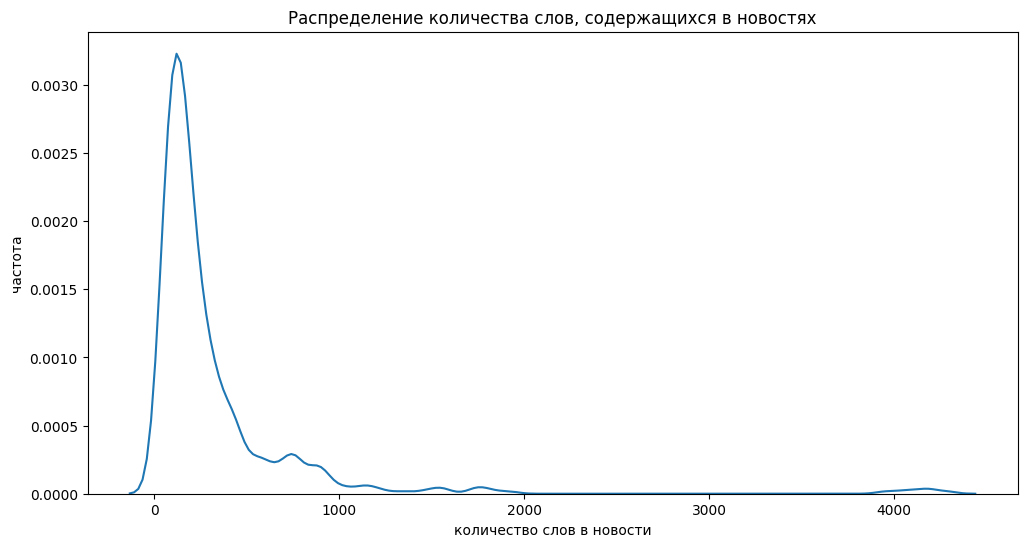

count     529.000000
mean      325.782609
std       504.559720
min        18.000000
25%       106.000000
50%       177.000000
75%       339.000000
max      4288.000000
Name: text, dtype: float64

In [16]:
get_stats_hist(data_news)

Чаще всего новость содержит около 177 слов. Но есть и такие новости, в которых слов сильно больше.

#### data_prices

In [17]:
# Функция для отображения гистограмм стоимостей
def plt_hist(df):
    plt.figure(figsize=(16, 8))
    cols = ['RGBI', 'IMOEXF', 'RAGR', 'Urals']
    
    for i, clm_n in enumerate(cols):
        plt.subplot(2, 2, i+1)
        if df[clm_n].nunique() >= 20 and pd.api.types.is_numeric_dtype(df[clm_n]):
            axes = sns.kdeplot(data=df, x=clm_n, bw_method=0.1)
        else:
            continue
        axes.set_ylabel('частота')

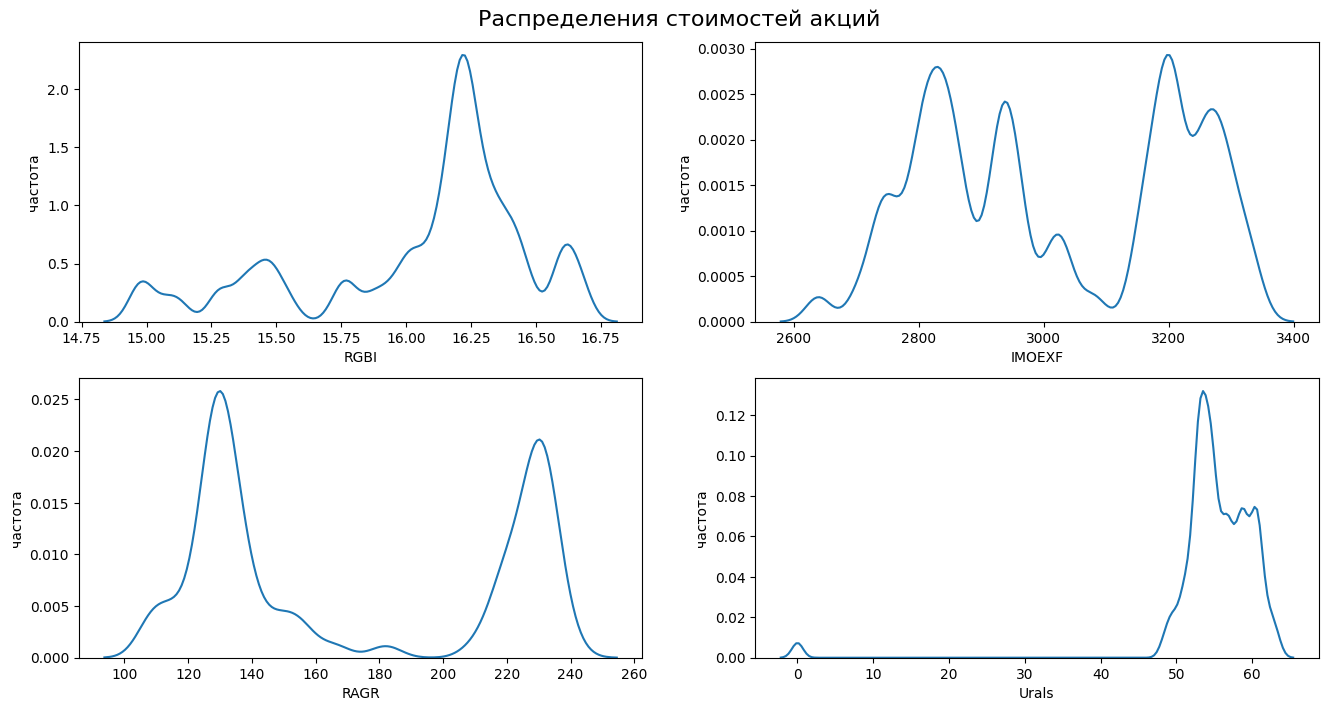

In [18]:
plt_hist(data_prices)
plt.suptitle('Распределения стоимостей акций', y=0.92, fontsize=16)

plt.show()

Наблюдается аномальное значение стоимости акции `Urals` равное 0.

In [19]:
display(data_prices.query('Urals == 0'))
# Было бы неплохо заменить на реальное значение, но что-то не нашел идентичное распределение
data_prices.loc[73, 'Urals'] = data_prices.loc[72, 'Urals']

,TRADEDATE,RGBI,IMOEXF,RAGR,Urals
73,2025-05-29,16.02,2813.0,109.2,0.0


Нулевое значение стоимости акции `Urals` было заменено на стоимость акции предыдущего дня.

In [20]:
# Функция для отображения признаков в зависимости от даты
def plt_hist_time(df):
    plt.figure(figsize=(16, 10))
    i = 1
    cols = df.columns[1:]
    
    for clm_n in cols:
        plt.subplot(2, 2, i)
        if pd.api.types.is_numeric_dtype(df[clm_n]):
            sns.scatterplot(data=df, x='TRADEDATE', y=clm_n,)
            plt.xticks(rotation=10)
        i += 1

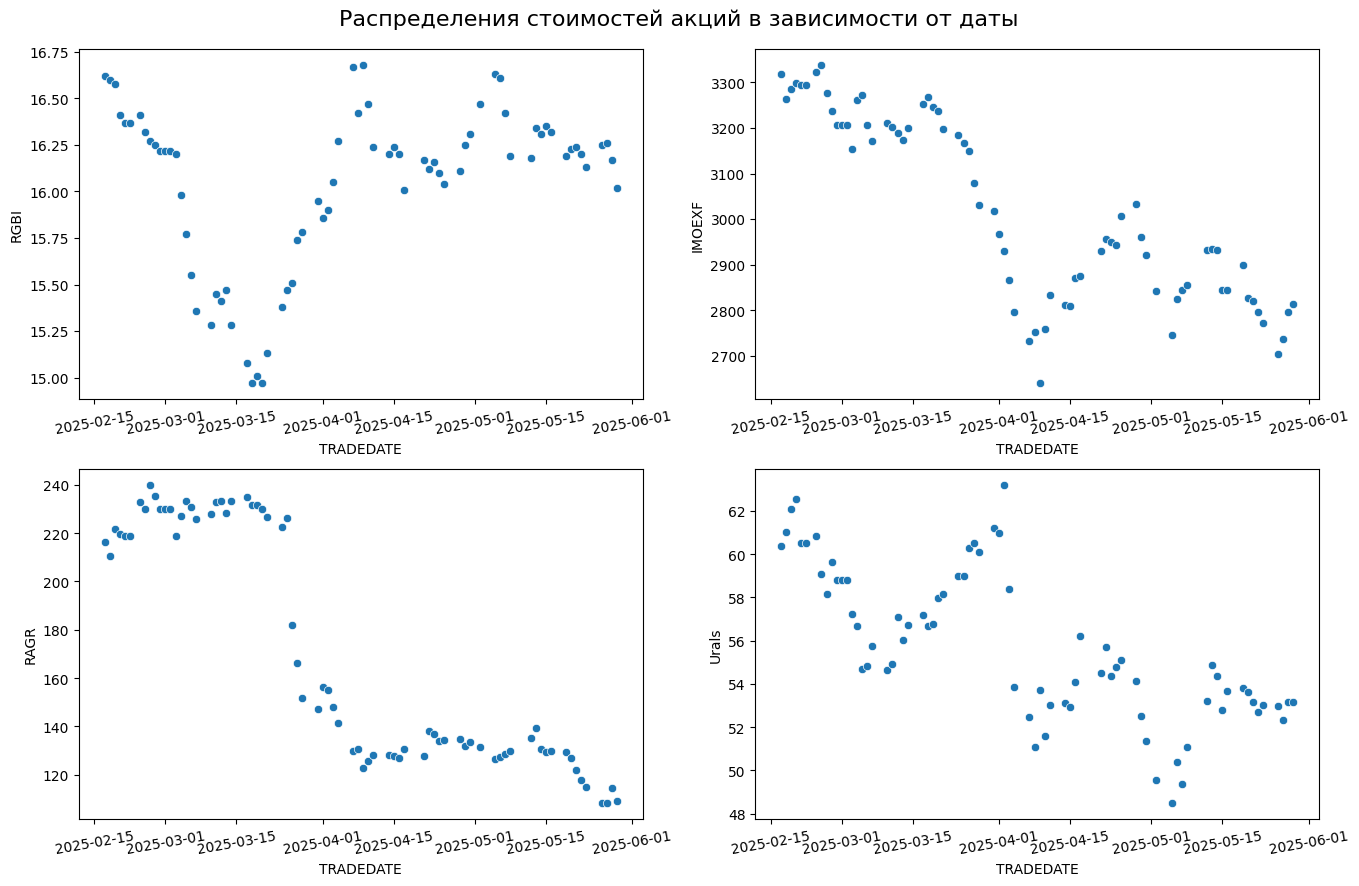

In [21]:
plt_hist_time(data_prices)
plt.suptitle('Распределения стоимостей акций в зависимости от даты', y=0.92, fontsize=16)

plt.show()

Наблюдается "медвежий тренд" акций Русарго.

#### data_ragr

In [22]:
data_ragr = data_prices.merge(data_news, left_on='TRADEDATE', right_on='story_date', how='inner')

data_ragr.drop(['story_date'], axis=1, inplace=True)
display(data_ragr.head())
print('Количество строк в объединенной таблице:', data_ragr.shape[0])

,TRADEDATE,RGBI,IMOEXF,RAGR,Urals,story_id,title,text,language,source,url,char_length,token_count
0,2025-02-17,16.62,3319.5,216.34,60.395,387746,ставка цб индекс мосбиржи старт торгов акциями...,ставка цб индекс мосбиржи старт торгов акциями...,ru,https://news.mail.ru/rss/economics/90/,https://news.mail.ru/economics/64905638/,7435,1947
1,2025-02-17,16.62,3319.5,216.34,60.395,389038,акции русагро подскочили на 40 на старте торго...,акции русагро подскочили на 40 на старте торго...,ru,https://news.mail.ru/rss/economics/90/,https://news.mail.ru/economics/64907729/,4192,962
2,2025-02-18,16.60,3264.0,210.50,61.015,398472,власти начали обсуждение повышенного налога по...,власти начали обсуждение повышенного налога по...,ru,https://news.mail.ru/rss/economics/90/,https://news.mail.ru/economics/64921034/,6093,1540
3,2025-02-18,16.60,3264.0,210.50,61.015,398785,минфин начал обсуждение проблемы повышенного н...,минфин начал обсуждение проблемы повышенного н...,ru,https://vedomosti.ru/rss/news,https://www.vedomosti.ru/investments/news/2025...,2520,610
4,2025-02-18,16.60,3264.0,210.50,61.015,399322,минфин в ответ на жалобы инвесторов на повышен...,минфин в ответ на жалобы инвесторов на повышен...,ru,https://www.forbes.ru/newrss.xml,https://www.forbes.ru/investicii/531040-minfin...,4305,967


Количество строк в объединенной таблице: 463


Датасеты были обьеденены. Получилось 463 новости, имеющих в эти же дни данные о ценах акций.

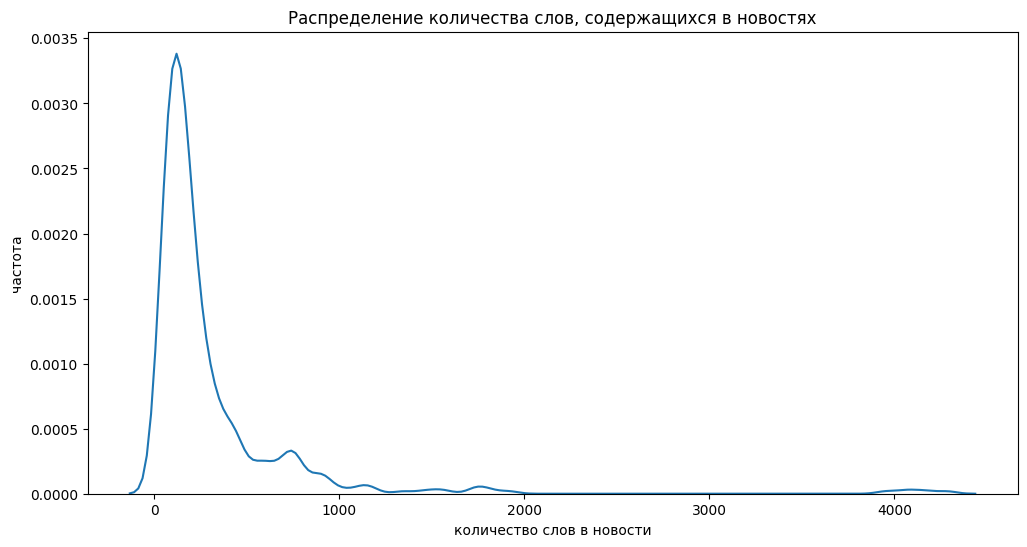

count     463.000000
mean      314.563715
std       496.301490
min        18.000000
25%       101.500000
50%       168.000000
75%       317.000000
max      4288.000000
Name: text, dtype: float64

In [23]:
get_stats_hist(data_ragr)

Распределение количества слов, содержащихся в новостях таблицы **`data_ragr`** репрезентативно с **`data_news`**.

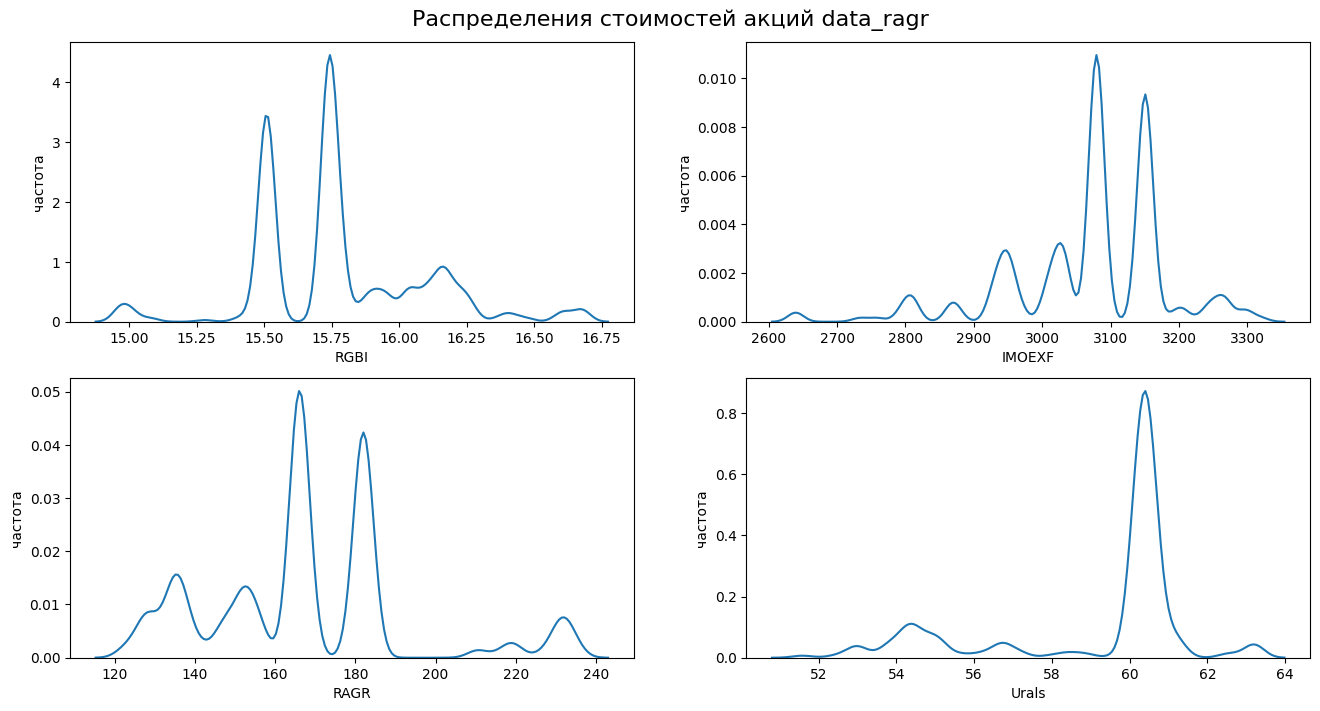

In [24]:
plt_hist(data_ragr)
plt.suptitle('Распределения стоимостей акций data_ragr', y=0.92, fontsize=16)

plt.show()

Распределения стоимостей акций датасета **`data_ragr`** по сравнению с  **`data_prices`** стали более импульсивными. Это связано с тем, что датасеты были соеденены внутренне и не все даты попали в таблицу.

#### Вывод исследовательского анализа

В датасете **`data_prices`** было обнаружено аномальное значение признака `Urals` равное нулю. \
Третий квартиль количества слов в новостях равен 317 - это не может не радовать. \
Обьединенный датасет имеет 463 новости, имеющих в эти же дни данные о ценах акций. \
Наблюдается "медвежий тренд" акций Русарго. 


### Модель для предсказания сентимента

#### Импорт модели и проверка предсказаний

In [25]:
tokenizer = AutoTokenizer.from_pretrained("mxlcw/rubert-tiny2-russian-financial-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("mxlcw/rubert-tiny2-russian-financial-sentiment")

print('Модель в тренировочном режиме' if model.training else 'Модель в режиме инференса')


# Функция для тестирования предобученной модели
def predict_proba(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1).squeeze()

    sentiment_score = probs[1] - probs[2] # В отрезке [-1, 1]
    
    return round(float(sentiment_score), 4)

Модель в режиме инференса


Найдена модель, дообученная на финансовых новостях (Telegram Financial Sentiment (ru)). [Файл конфигурации модели](https://huggingface.co/mxlcw/rubert-tiny2-russian-financial-sentiment/blob/main/config.json). \
Замечательно, что модель способна принимать до 2048 токенов — в отличие от стандартных 512 токенов у большинства BERT-моделей.

In [26]:
text_1 = 'Директор компании обвиняется в краже. Его ждет срок заключения до 10 лет лишения свободы.'
text_2 = 'За последний год количество сотрудников не изменилось, продолжается работа над проектом.'
text_3 = 'После подписания договора, акции компании увеличились на 10%.'

In [27]:
print(text_1, f'Вероятность метки: {predict_proba(text_1)}', sep='\n')

Директор компании обвиняется в краже. Его ждет срок заключения до 10 лет лишения свободы.
Вероятность метки: -0.8574


In [28]:
print(text_2, f'Вероятность метки: {predict_proba(text_2)}', sep='\n')

За последний год количество сотрудников не изменилось, продолжается работа над проектом.
Вероятность метки: -0.3098


In [29]:
print(text_3, f'Вероятность метки: {predict_proba(text_3)}', sep='\n')

После подписания договора, акции компании увеличились на 10%.
Вероятность метки: 0.9775


Модель демонстрирует высокую точность в предсказании сентимента.

#### Предсказание сентимента

In [30]:
# Функция для предсказания сентимента (с скользящим окном в случае длинных новостей)
def predict_sentiment_with_chunks(text, max_length=2048, stride=128):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        stride=stride,
        return_overflowing_tokens=True,
        padding='max_length'
    )

    valid_keys = ['input_ids', 'attention_mask', 'token_type_ids']
    inputs = {k: v for k, v in inputs.items() if k in valid_keys}

    num_chunks = inputs['input_ids'].shape[0]
    sentiment_scores = []

    with torch.no_grad():
        for i in range(num_chunks):
            inputs_chunk = {k: v[i].unsqueeze(0) for k, v in inputs.items()}
            outputs = model(**inputs_chunk)
            probs = F.softmax(outputs.logits, dim=-1).squeeze()
            sentiment_scores.append(probs[1] - probs[2])

    avg_sentiment_scores = sum(sentiment_scores) / len(sentiment_scores)
    return round(float(avg_sentiment_scores.item()), 4)

In [31]:
# Функция для прогресс бара с вероятностью сентимента
def progress_preds(df, clm='text'):
    tqdm.pandas(desc="Предсказание вероятности сентимента")
    return df[clm].progress_apply(predict_sentiment_with_chunks)

In [32]:
data_ragr['sentiment_score'] = progress_preds(data_ragr)

Предсказание вероятности сентимента: 100%|██████████| 463/463 [00:35<00:00, 13.12it/s]


In [33]:
data_ragr.head()

,TRADEDATE,RGBI,IMOEXF,RAGR,Urals,story_id,title,text,language,source,url,char_length,token_count,sentiment_score
0,2025-02-17,16.62,3319.5,216.34,60.395,387746,ставка цб индекс мосбиржи старт торгов акциями...,ставка цб индекс мосбиржи старт торгов акциями...,ru,https://news.mail.ru/rss/economics/90/,https://news.mail.ru/economics/64905638/,7435,1947,0.1066
1,2025-02-17,16.62,3319.5,216.34,60.395,389038,акции русагро подскочили на 40 на старте торго...,акции русагро подскочили на 40 на старте торго...,ru,https://news.mail.ru/rss/economics/90/,https://news.mail.ru/economics/64907729/,4192,962,0.8193
2,2025-02-18,16.60,3264.0,210.50,61.015,398472,власти начали обсуждение повышенного налога по...,власти начали обсуждение повышенного налога по...,ru,https://news.mail.ru/rss/economics/90/,https://news.mail.ru/economics/64921034/,6093,1540,0.0450
3,2025-02-18,16.60,3264.0,210.50,61.015,398785,минфин начал обсуждение проблемы повышенного н...,минфин начал обсуждение проблемы повышенного н...,ru,https://vedomosti.ru/rss/news,https://www.vedomosti.ru/investments/news/2025...,2520,610,-0.6894
4,2025-02-18,16.60,3264.0,210.50,61.015,399322,минфин в ответ на жалобы инвесторов на повышен...,минфин в ответ на жалобы инвесторов на повышен...,ru,https://www.forbes.ru/newrss.xml,https://www.forbes.ru/investicii/531040-minfin...,4305,967,-0.2251


#### Анализ результатов

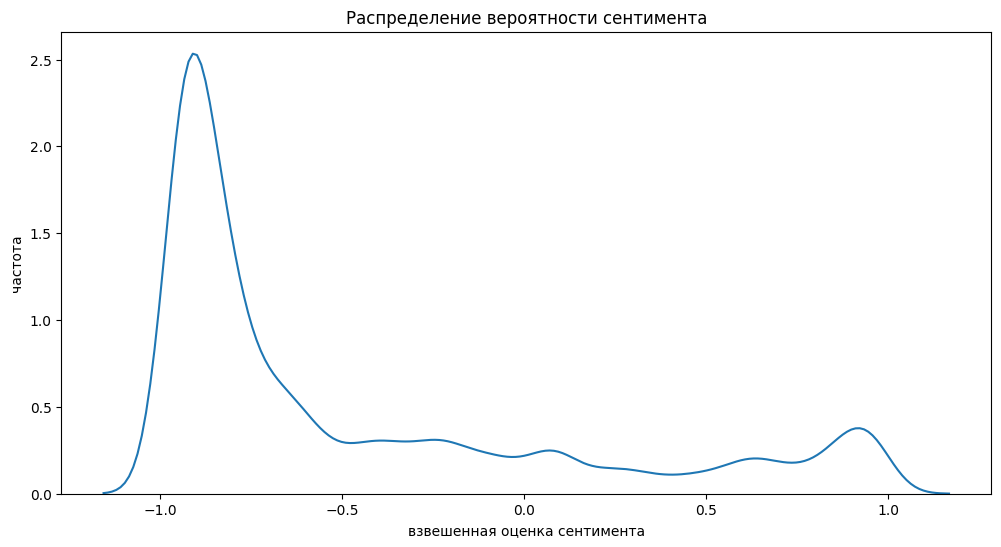

In [34]:
plt.figure(figsize=(12, 6))
plt.title('Распределение вероятности сентимента')
sns.kdeplot(data=data_ragr['sentiment_score'], bw_method=0.1)

plt.ylabel('частота')
plt.xlabel('взвешенная оценка сентимента')
plt.show()

Согласно распределению, новости с негативным контекстом преобладают в датасете.

In [35]:
group_date = data_ragr.pivot_table(index='TRADEDATE', values=['sentiment_score', 'RGBI', 'IMOEXF', 'RAGR', 'Urals'])
print('В хронологическом ли порядке расположены даты:', 'да' if group_date.index.is_monotonic_increasing else 'нет')

В хронологическом ли порядке расположены даты: да


In [36]:
scaler = MinMaxScaler()

scaled = scaler.fit_transform(group_date)
scaled_prices_sem = pd.DataFrame(data=scaled, columns=scaler.get_feature_names_out(), index=group_date.index)

Стоимости акций и оценка сентимента были стандартизированы.

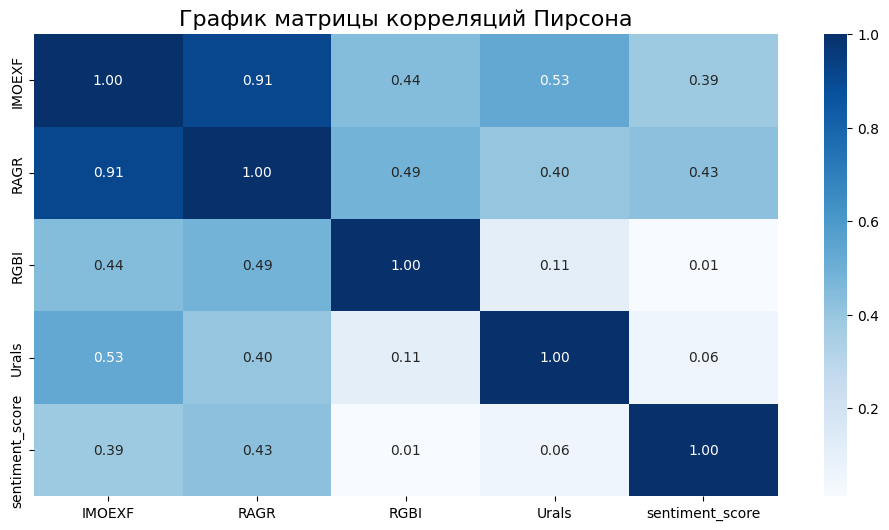

In [37]:
plt.figure(figsize=(12, 6))

plt.title('График матрицы корреляций Пирсона', fontsize=16)
sns.heatmap(np.abs(scaled_prices_sem.corr()),
            annot=True,
            fmt='.2f',
            cmap='Blues')

plt.show()

Оценка сентимента имеет умеренную, по шкале Чеддока, линейную связь с `IMOEXF` и `RAGR`.

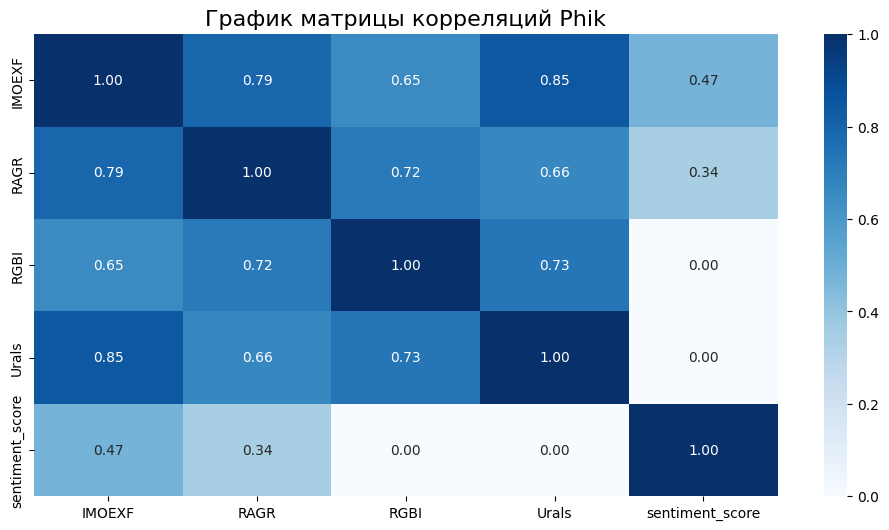

In [38]:
plt.figure(figsize=(12, 6))

plt.title('График матрицы корреляций Phik', fontsize=16)
sns.heatmap(scaled_prices_sem.phik_matrix(interval_cols=['sentiment_score', 'IMOEXF', 'RAGR', 'RGBI', 'Urals']),
            annot=True,
            fmt='.2f',
            cmap='Blues')

plt.show()

Корреляция Phik подтверждает некоторую зависимость `sentiment_score` с признаками `IMOEXF` и `RAGR`.

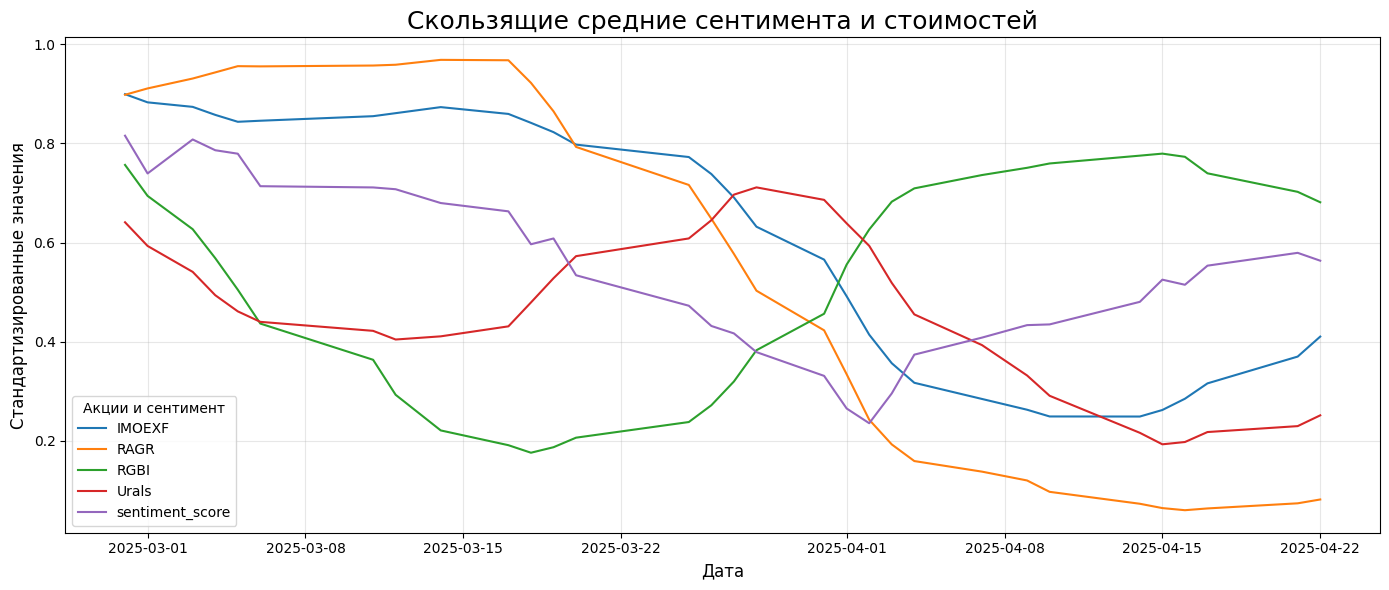

In [ ]:
df_prices_sem = (scaled_prices_sem.rolling(10, center=True).mean().reset_index()
             .melt(id_vars='TRADEDATE', var_name='Акции и сентимент', value_name='Значение'))


plt.figure(figsize=(14, 6))
sns.lineplot(data=df_prices_sem, x='TRADEDATE', y='Значение', hue='Акции и сентимент')

plt.title('Скользящие средние сентимента и стоимостей', fontsize=18)
plt.ylabel('Стандартизированные значения', fontsize=12)
plt.xlabel('Дата', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()


На графике видна зависимость между `sentiment_score` и `RAGR`. Корреляция в полной мере не дает оценить связь из-за наличия временных рядов.

### Общий вывод работы

Были устранены дубликаты, приведены даты к единому формату, исправлены артефакты в тексте новостей, такие как нарезанные слова. Пропуски в ценовых данных были аккуратно заменены на значение прошлого дня, выбросы устранены.

Большинство новостей содержат от 100 до 300 слов, и наблюдается тенденция к снижению стоимости акций. Совмещение новостного и ценового датасетов позволило создать выборку из 463 записей, пригодных для последующего анализа. 

Для оценки сентимента новостей была использована модель **rubert-tiny2-russian-financial-sentiment**, дообученная на финансовых текстах. Модель показала высокую способность к адекватной оценке контекста. Предсказанные оценки сентимента были объединены с рыночными данными и стандартизированы для анализа зависимости.

Корреляционный анализ, включая метрику Phik, показал умеренную зависимость между `sentiment_score` и `RAGR`. Также была зафиксирована корреляция между сентиментом и индексом `MOEX`, что дополнительно подтверждает значимость новостного фона в рыночной динамике. График скользящих средних выявил визуальную сонаправленность динамики сентимента и стоимости акций компании.

Для повышения точности прогноза рекомендуется расширить период, попробовать дообучить модель на размеченных данных.